# 課程重點:
    
    利用Keras 建立神經網路模型
    
    查看優化器的結果

# 範例目標:
    
    使用CIFAR-10圖庫, 看看完整神經網路

In [1]:
from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import os


Using TensorFlow backend.


In [2]:
#Blas GEMM launch failed , 避免動態分配GPU / CPU, 出現問題
import tensorflow as tf
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))


In [3]:
batch_size = 32
num_classes = 10
epochs = 20
data_augmentation = True
num_predictions = 20
save_dir = os.path.join(os.getcwd(), 'saved_models')


In [4]:
# 檢查Dataset 的描述與資訊
# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


##    第一步：選擇模型, 順序模型是多個網絡層的線性堆疊

In [5]:
model = Sequential()

##   第二步：構建網絡層

In [6]:
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense( 10)) # 輸出結果是10個類別，所以維度是10   
model.add(Activation('softmax')) # 最後一層用softmax作為激活函數

In [7]:
# 模型建立完成後，統計參數總量
print("Total Parameters：%d" % model.count_params())

Total Parameters：1250858


In [8]:
# 輸出模型摘要資訊
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 64)        18496     
__________

## 第三步：編譯

In [9]:
import copy

Adam_model = copy.deepcopy(model)

Adam_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

C:\Users\tony8\Anaconda3\lib\site-packages\keras\engine\saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [10]:
# 資料正規化
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255



##   第四步：訓練
*   .fit的一些參數
*   batch_size：對總的樣本數進行分組，每組包含的樣本數量
*   epochs ：訓練次數
*   shuffle：是否把數據隨機打亂之後再進行訓練
*   validation_split：拿出百分之多少用來做交叉驗證
*   verbose：屏顯模式 - 0：不輸出, 1：輸出進度, 2：輸出每次的訓練結果
    

### 從現有圖片再新增資料
- 隨機水平移動
- 隨機垂直移動
- 隨機水平翻轉

In [11]:
# 是否要做資料處理
if not data_augmentation:
    print('Not using data augmentation.')
    history=model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
else:
    print('Using real-time data augmentation.')
    print('')
        
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset 將資料集的輸入平均值設為0
        samplewise_center=False,  # set each sample mean to 0 將每個樣本資料平均值設為0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset 資料集除以所有輸入的標準差
        samplewise_std_normalization=False,  # divide each input by its std 樣本除以自己的標準差
        zca_whitening=False,  # apply ZCA whitening ZCA白化
        zca_epsilon=1e-06,  # epsilon for ZCA whitening 白化數值
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180) 隨機旋轉度數範圍
        # randomly shift images horizontally (fraction of total width) 隨機水平移動百分比
        width_shift_range=0.1, 
        # randomly shift images vertically (fraction of total height) 隨機垂直移動百分比
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear 剪切強度
        zoom_range=0.,  # set range for random zoom 縮放強度
        channel_shift_range=0.,  # set range for random channel shifts 隨機通道轉換範圍
        # set mode for filling points outside the input boundaries 邊界外的點填充模式
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant" 邊界外點的值
        horizontal_flip=True,  # randomly flip images 隨機水平翻轉
        vertical_flip=False,  # randomly flip images 隨機垂直翻轉
        # set rescaling factor (applied before any other transformation) 縮放
        rescale=None,
        # set function that will be applied on each input 針對每個輸入進行處理
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last" 圖片數據格式
        # channels_last(samples, height, width, channels); channels_first(samples, channels, height, width)
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1) 用於驗證集資料的比例
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)
    Adam_history=Adam_model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)   

Using real-time data augmentation.

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 18s 358us/step - loss: 1.5149 - acc: 0.4484 - val_loss: 1.1603 - val_acc: 0.5853
Epoch 2/20
50000/50000 [==============================] - 15s 309us/step - loss: 1.1110 - acc: 0.6064 - val_loss: 0.9203 - val_acc: 0.6771
Epoch 3/20
50000/50000 [==============================] - 15s 310us/step - loss: 0.9492 - acc: 0.6666 - val_loss: 0.8454 - val_acc: 0.6968
Epoch 4/20
50000/50000 [==============================] - 16s 310us/step - loss: 0.8617 - acc: 0.6964 - val_loss: 0.7593 - val_acc: 0.7370
Epoch 5/20
50000/50000 [==============================] - 16s 311us/step - loss: 0.8008 - acc: 0.7196 - val_loss: 0.7146 - val_acc: 0.7507
Epoch 6/20
50000/50000 [==============================] - 16s 312us/step - loss: 0.7581 - acc: 0.7349 - val_loss: 0.7169 - val_acc: 0.7516
Epoch 7/20
50000/50000 [==============================] - 16s 313us/step - loss:

## 第五步：儲存模型與參數

In [12]:
model_name_Adam = 'keras_cifar10_Adam_model.h5'

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name_Adam)
Adam_model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at C:\Users\tony8\OneDrive\文件\Machine_Learning\D76\saved_models\keras_cifar10_Adam_model.h5 


##    第六步：輸出

In [13]:
# Score trained model.
Adam_scores = Adam_model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', Adam_scores[0])
print('Test accuracy:', Adam_scores[1])

10000/10000 [==============================] - 1s 102us/step
Test loss: 0.6570931728839874
Test accuracy: 0.7856


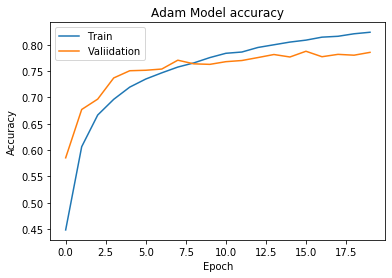

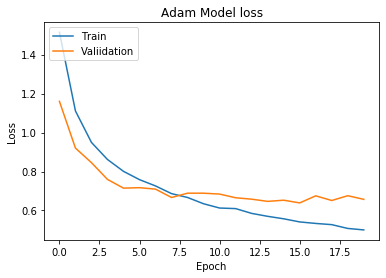

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

# Plot training & validation accuracy values
plt.plot(Adam_history.history['acc'])
plt.plot(Adam_history.history['val_acc'])
plt.title('Adam Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valiidation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(Adam_history.history['loss'])
plt.plot(Adam_history.history['val_loss'])
plt.title('Adam Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valiidation'], loc='upper left')
plt.show()

# 作業重點:

(1)以, Adam, 為例, 調整 batch_size, epoch , 觀察accurancy, loss 的變化

(2)以同一模型, 分別驗證 SGD, Adam, Rmsprop 的 accurancy

# 作業目標:
    
    取得各種優化器的運算結果


### SGD(隨機梯度下降) - Arguments
- lr: float >= 0. Learning rate.
- momentum: float >= 0. Parameter that accelerates SGD in the relevant direction and dampens oscillations.
- decay: float >= 0. Learning rate decay over each update.
- nesterov: boolean. Whether to apply Nesterov momentum.

### RMSprop- Arguments
- lr: float >= 0. Learning rate.
- rho: float >= 0.
- epsilon: float >= 0. Fuzz factor. If None, defaults to K.epsilon().
- decay: float >= 0. Learning rate decay over each update.

In [15]:
#第三步編譯
from keras import optimizers
import copy


SGD_model = copy.deepcopy(model)
RMSprop_model = copy.deepcopy(model)

sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
rmsprop = optimizers.RMSprop(lr=0.0001, rho=0.9, epsilon=None, decay=1e-6)


#model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])
SGD_model.compile(optimizer = sgd, loss = 'categorical_crossentropy', metrics = ['accuracy'])
RMSprop_model.compile(optimizer = rmsprop, loss = 'categorical_crossentropy', metrics = ['accuracy'])


C:\Users\tony8\Anaconda3\lib\site-packages\keras\engine\saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [16]:
model_name_SGD = 'keras_cifar10_SGD_model.h5'

SGD_history=SGD_model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, y_test),
          shuffle=True)  

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 14s 285us/step - loss: 1.7443 - acc: 0.3601 - val_loss: 1.5155 - val_acc: 0.4546
Epoch 2/20
50000/50000 [==============================] - 14s 275us/step - loss: 1.3239 - acc: 0.5228 - val_loss: 1.0728 - val_acc: 0.6219
Epoch 3/20
50000/50000 [==============================] - 14s 275us/step - loss: 1.1438 - acc: 0.5932 - val_loss: 0.9597 - val_acc: 0.6618
Epoch 4/20
50000/50000 [==============================] - 14s 273us/step - loss: 1.0262 - acc: 0.6363 - val_loss: 0.9226 - val_acc: 0.6775
Epoch 5/20
50000/50000 [==============================] - 14s 273us/step - loss: 0.9470 - acc: 0.6683 - val_loss: 0.8352 - val_acc: 0.7110
Epoch 6/20
50000/50000 [==============================] - 14s 274us/step - loss: 0.8919 - acc: 0.6886 - val_loss: 0.7917 - val_acc: 0.7280
Epoch 7/20
50000/50000 [==============================] - 14s 273us/step - loss: 0.8508 - acc: 0.6999 - val_loss: 0.

In [17]:
model_name_RMSprop = 'keras_cifar10_RMSprop_model.h5'

RMSprop_history=RMSprop_model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, y_test),
          shuffle=True)  

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 15s 305us/step - loss: 1.7971 - acc: 0.3415 - val_loss: 1.5374 - val_acc: 0.4390
Epoch 2/20
50000/50000 [==============================] - 15s 294us/step - loss: 1.5053 - acc: 0.4575 - val_loss: 1.3556 - val_acc: 0.5110
Epoch 3/20
50000/50000 [==============================] - 15s 294us/step - loss: 1.3625 - acc: 0.5077 - val_loss: 1.3106 - val_acc: 0.5390
Epoch 4/20
50000/50000 [==============================] - 15s 294us/step - loss: 1.2630 - acc: 0.5507 - val_loss: 1.1663 - val_acc: 0.5856
Epoch 5/20
50000/50000 [==============================] - 15s 294us/step - loss: 1.1870 - acc: 0.5797 - val_loss: 1.1910 - val_acc: 0.5844
Epoch 6/20
50000/50000 [==============================] - 15s 294us/step - loss: 1.1226 - acc: 0.6039 - val_loss: 1.0398 - val_acc: 0.6272
Epoch 7/20
50000/50000 [==============================] - 15s 300us/step - loss: 1.0682 - acc: 0.6254 - val_loss: 0.

In [18]:
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
    
model_path = os.path.join(save_dir, model_name_SGD)
SGD_model.save(model_path)
print('Saved trained model at %s ' % model_path)

model_path = os.path.join(save_dir, model_name_RMSprop)
RMSprop_model.save(model_path)
print('Saved trained model at %s ' % model_path)

# Score trained model.
print("")
print("SGD")
SGD_scores = SGD_model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', SGD_scores[0])
print('Test accuracy:', SGD_scores[1])

print("")
print("RMSprop")
RMSprop_scores = RMSprop_model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', RMSprop_scores[0])
print('Test accuracy:', RMSprop_scores[1])

Saved trained model at C:\Users\tony8\OneDrive\文件\Machine_Learning\D76\saved_models\keras_cifar10_SGD_model.h5 
Saved trained model at C:\Users\tony8\OneDrive\文件\Machine_Learning\D76\saved_models\keras_cifar10_RMSprop_model.h5 

SGD
10000/10000 [==============================] - 1s 104us/step
Test loss: 0.720620187330246
Test accuracy: 0.7569

RMSprop
10000/10000 [==============================] - 1s 105us/step
Test loss: 0.718722839641571
Test accuracy: 0.7508


In [19]:
import numpy 

print ( " test set on SGD" )
SGD_scores = SGD_model.evaluate(x_test,y_test,batch_size=200,verbose= 0)
print ( "" )
print ( " The test loss is %f ", SGD_scores)


result = SGD_model.predict(x_test,batch_size=200,verbose= 0)

result_max = numpy.argmax(result, axis = 1 )
test_max = numpy.argmax(y_test, axis = 1 )

result_bool = numpy.equal(result_max, test_max)
true_num = numpy.sum(result_bool)

print(f' {true_num}/{x_test.shape[0]}')

 test set on SGD

 The test loss is %f  [0.7206201934814453, 0.7569000041484832]
 7569/10000


In [20]:
print ( " test set on RMSprop" )
RMSprop_scores = RMSprop_model.evaluate(x_test,y_test,batch_size=200,verbose= 0)
print ( "" )
print ( " The test loss is %f ", RMSprop_scores)


result = RMSprop_model.predict(x_test,batch_size=200,verbose= 0)

result_max = numpy.argmax(result, axis = 1 )
test_max = numpy.argmax(y_test, axis = 1 )

result_bool = numpy.equal(result_max, test_max)
true_num = numpy.sum(result_bool)

print(f' {true_num}/{x_test.shape[0]}')

 test set on RMSprop

 The test loss is %f  [0.7187228381633759, 0.7507999980449677]
 7508/10000


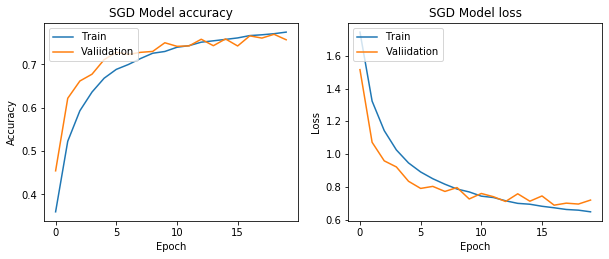

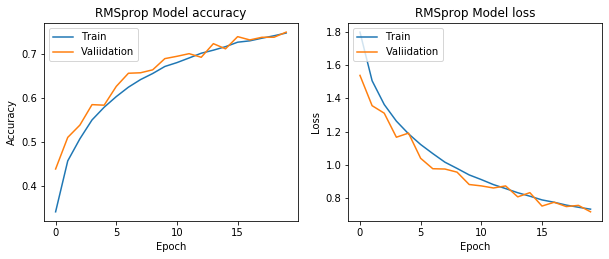

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'

# Plot training & validation accuracy values
plt.subplot(2,2,1)
plt.plot(SGD_history.history['acc'])
plt.plot(SGD_history.history['val_acc'])
plt.title('SGD Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valiidation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(2,2,2)
plt.plot(SGD_history.history['loss'])
plt.plot(SGD_history.history['val_loss'])
plt.title('SGD Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valiidation'], loc='upper left')
plt.show()


plt.subplot(2,2,3)
plt.plot(RMSprop_history.history['acc'])
plt.plot(RMSprop_history.history['val_acc'])
plt.title('RMSprop Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valiidation'], loc='upper left')

plt.subplot(2,2,4)
plt.plot(RMSprop_history.history['loss'])
plt.plot(RMSprop_history.history['val_loss'])
plt.title('RMSprop Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valiidation'], loc='upper left')
plt.show()

#### Result
- Adam Accuracy大約落在78%
- SGD Accuracy大約落在75%
- RMSprop Accuracy大約落在75% (Learning_Rate相較於上述兩個要小很多)